In [1]:
import copy
from kaggle_environments import make as kaggle_make
from kaggle_environments.envs.hungry_geese.hungry_geese import Action, Configuration, Observation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy import special, stats
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from hungry_geese.utils import ActionMasking
from hungry_geese.env import goose_env as ge
from hungry_geese.env.lightweight_env import LightweightEnv, make
from hungry_geese.mcts.basic_mcts import BasicMCTS
from hungry_geese.sl.alphagoose_dataloader import AlphaGooseDataset, RandomReflect, alphagoose_collate_fn

%matplotlib inline

Loading environment football failed: No module named 'gfootball'


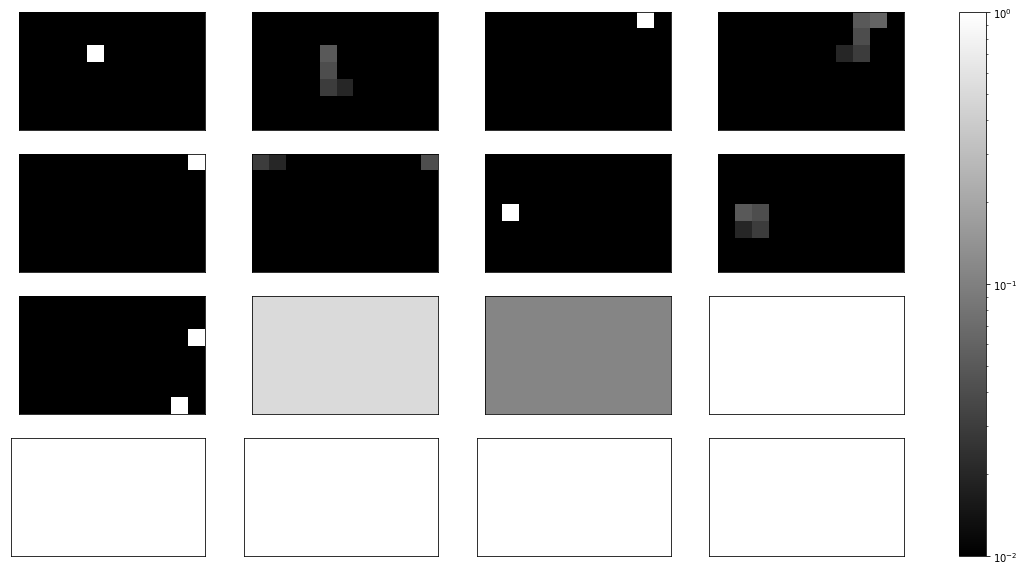

In [55]:
import matplotlib.colors as colors
for s, a, r, hl, alive in ag_dataloader:
    square = np.ceil(np.sqrt(s.shape[1])).astype(np.int)
    fig, axs = plt.subplots(square, square, figsize=(20,10))
    ix = 0
    for i in range(square):
        for j in range(square):
            ax = axs[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            eps = 1e-2
            if ix < s.shape[1]:
                pcm = ax.imshow(s[0, ix, :, :] + eps, norm=colors.LogNorm(vmin=eps, vmax=1.), cmap='gray')
                ix += 1
    fig.colorbar(pcm, ax = axs)
    plt.show()
    break

In [4]:
env = make('hungry_geese')
env.reset(num_agents=4);

In [3]:
def action_mask_func(state):
    return ActionMasking.LETHAL.get_action_mask(state)

def actor_func(state):
    return np.zeros((len(state), 4)) + 0.25
    
# Geese are evaluated based on the proportion of their length to the total length of all geese
# This value is then rescaled to account for geese that have already died
# Finally, the overall rankings and ranking estimates are rescaled to be from -1 to 1
def critic_func(state):
    n_geese = float(len(state))
    goose_lengths = np.array([len(goose) for goose in state[0]['observation']['geese']]).astype(np.float)
    dead_geese_mask = goose_lengths == 0
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    agent_rankings_rescaled = agent_rankings / (n_geese - 1.)
    
    # Deprecated: goose_lengths_norm = goose_lengths / goose_lengths.sum()
    l_mod = state[0]['observation']['step'] / 200.
    goose_lengths_norm = special.softmax(np.where(
        dead_geese_mask,
        float('-inf'),
        goose_lengths * l_mod
    ))
    remaining_equity = n_geese / 2. - np.sum(np.arange(dead_geese_mask.sum()) / (n_geese - 1.))
    goose_lengths_norm_rescaled = goose_lengths_norm * remaining_equity
    
    final_ranks = np.where(
        dead_geese_mask,
        agent_rankings_rescaled,
        goose_lengths_norm_rescaled
    )
    if not np.isclose(final_ranks.sum(), n_geese / 2.):
        raise RuntimeError(f'Final ranks should sum to {n_geese / 2.}\n'
                           f'Final ranks: {final_ranks}\nDead geese mask: {dead_geese_mask}')
    return 2. * final_ranks - 1.
    
def terminal_value_func(state):
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    ranks_rescaled = 2. * agent_rankings / (len(state) - 1.) - 1.
    return ranks_rescaled
    
def actor_critic_func(state):
    return actor_func(state), critic_func(state)

In [5]:
print(env.render_ansi())

search_tree = BasicMCTS(
    action_mask_func=action_mask_func,
    actor_critic_func=actor_critic_func,
    terminal_value_func=terminal_value_func,
    c_puct = np.sqrt(2.),
)
root_node = search_tree.run_mcts(
    env=env,
    n_iter=10000,
    max_time=1.
)

+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   | 3 |   |   | 0 |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 1 |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   | F |   |   |   |   |   | 2 |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | F |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+



In [13]:
root_node.n_visits
root_node.q_vals

array([[-0.01133309, -0.00866546, -0.04116001,  0.00154068],
       [ 0.00330338, -0.01095515, -0.00121598,  0.01584697],
       [ 0.00630528,  0.00585535,  0.01161997, -0.0105666 ],
       [-0.01904349, -0.0149516 ,  0.00303559,  0.01530704]])

In [58]:
food_dists = np.array([[0, 2, 2, 2],
                       [1, 3, 3, 3],
                       [2, 2, 4, 4],
                       [3, 3, 5, 5],
                       [6, 6, 8, 8]])
special.softmax(1. / np.log((food_dists + 1.) * 1 + 1.), axis=-1)

array([[0.40678677, 0.19773774, 0.19773774, 0.19773774],
       [0.30795272, 0.23068243, 0.23068243, 0.23068243],
       [0.27035942, 0.27035942, 0.22964058, 0.22964058],
       [0.26341667, 0.26341667, 0.23658333, 0.23658333],
       [0.25582443, 0.25582443, 0.24417557, 0.24417557]])

In [68]:
special.softmax(1. / ((food_dists + 1.) * 2), axis=-1)

array([[0.31750125, 0.22749958, 0.22749958, 0.22749958],
       [0.27416108, 0.24194631, 0.24194631, 0.24194631],
       [0.25833025, 0.25833025, 0.24166975, 0.24166975],
       [0.25520758, 0.25520758, 0.24479242, 0.24479242],
       [0.25198409, 0.25198409, 0.24801591, 0.24801591]])

(0.0, 1.0)

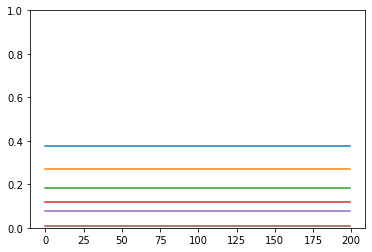

In [26]:
goose_lengths = np.array([
    [0, 1],
    [0, 2],
    [0, 3],
    [0, 4],
    [0, 5],
    [0, 10]
])
win_pcts = []
for step in range(200):
    # l_mod = step / 200.
    l_mod = 0.5 / 1.
    win_pcts.append(special.softmax(goose_lengths * l_mod, axis=-1)[:, 0])
plt.plot(win_pcts)
plt.ylim((0., 1.))